# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [68]:
import pandas as pd 
import json 
from collections import Counter
import string 
import re 
import numpy as np
import spacy
# from spellchecker import SpellChecker
from autocorrect import Speller
from pathlib import Path
import os

# Also install the following packages
# pip install pyarrow
# pip install torch
# pip install scikit-learn


In [69]:
from IPython.core.magic import register_cell_magic

# Custom magic command to skip the cell
@register_cell_magic
def skip(line, cell):
    return


In [70]:
def mojority_of_votes(votes:list):
    """ given an array of votes, return the mode or None if there is no mode """
    count = Counter(votes)
    most_common = count.most_common(2)
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return None
    if most_common:
        return most_common[0][0]

In [71]:
def preprocess(data:pd.DataFrame):
    # method for all the preprocessing steps
    data = data.T # make the attributes as columns and data points as rows
    data['hard_label_task1'] = data['labels_task1'].apply(mojority_of_votes) #generate hard labels 
    data = data[data['hard_label_task1'].notna()] # drop rows without a majority label
    data = data[data['lang'] == 'en'] # drop rows where lang is not 'en'
    data = data[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']] # keeping only necessary columns
    data['hard_label_task1'] = data['hard_label_task1'].map({'YES': 1, 'NO': 0}) # encoding 'hard_label_task1' column
    return data

In [72]:
data_training = pd.read_json(Path('data', 'training.json'))
data_test = pd.read_json(Path('data', 'test.json'))
data_validation = pd.read_json(Path('data', 'validation.json'))

data_training = preprocess(data_training)
data_test = preprocess(data_test)
data_validation = preprocess(data_validation)

data_training.head()


,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [73]:
!python -m spacy download en

/home/habib/Projects/NLP/Unibo/Course_Project/nlp_assignment_1/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [74]:
# spaCy English model
nlp = spacy.load('en_core_web_sm')
spell = Speller()

In [75]:

def remove_emojis(text):
    # removing emojis with regex, including 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F914"  # 🤔
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_special_characters(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_quotes(text):
    return text.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')

def lemmatize_text(text):
    # performing lemmatization using spacy
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# =================== Additional preprocessing techniques =================================
# important to reduce the number of unseen vobabs as Glove contains mostly lowercase tokens
def lowercase_text(text): 
    return text.lower()  # convert all text to lowercase

def correct_typos(text):
    return spell(text)

def clean_text(tweet):
    tweet = remove_emojis(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_urls(tweet)
    tweet = remove_special_characters(tweet)
    tweet = remove_quotes(tweet)
    tweet = lowercase_text(tweet)
    tweet = correct_typos(tweet)
    tweet = lemmatize_text(tweet)
    tweet = tweet.strip()
    return tweet


In [76]:
# testing if all is fine
sample_text = "this is awsome bro! 😁 @johnsmith #wait www.google.com"
clean_text(sample_text)

'this be awesome bro'

In [77]:
%%skip
# If you want to clean the entire dataset, instead of loading the cleaned dataset,
# comment the skip magic command and run the cell
def clean_dataset_tweets(data:pd.DataFrame):    
    data['tweet'] = data['tweet'].apply(clean_text)
    return data 

data_training_cleaned = clean_dataset_tweets(data_training)
data_test_cleaned = clean_dataset_tweets(data_test)
data_validation_cleaned = clean_dataset_tweets(data_validation)

data_training_cleaned.head()

In [78]:
stored_data_dir = "stored_data"

# Define file paths
training_path = os.path.join(stored_data_dir, 'data_training_cleaned.parquet')
test_path = os.path.join(stored_data_dir, 'data_test_cleaned.parquet')
validation_path = os.path.join(stored_data_dir, 'data_validation_cleaned.parquet')

In [79]:
%%skip
# If you want to save the cleaned dataset, comment the skip magic command 
# and run the cell

if not os.path.exists(stored_data_dir):
    os.makedirs(stored_data_dir)

# Save the cleaned datasets to Parquet
data_training_cleaned.to_parquet(training_path, index=False)
data_test_cleaned.to_parquet(test_path, index=False)
data_validation_cleaned.to_parquet(validation_path, index=False)

In [80]:
# Load the saved cleaned datasets from disk
data_training_cleaned = pd.read_parquet(training_path)
data_test_cleaned = pd.read_parquet(test_path)
data_validation_cleaned = pd.read_parquet(validation_path)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

## Embedding Strategy

For this project, this pretrained word vector is used:

`Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors, 822 MB download)`

which can be downlaoded from https://github.com/stanfordnlp/GloVe?tab=readme-ov-file

In [81]:
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:embedding_dim+1], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Example usage
glove_file_path = Path('glove.6B', 'glove.6B.50d.txt') #we choose the XYZ dim
embedding_dim = 50  # You can choose any dimension

glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)

In [82]:
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
def create_vocabulary_and_embeddings(train_tokens, glove_embeddings, embedding_dim):
    vocab = {} #to store the training set tokens and their indices
    embedding_matrix = [] #to store all the embedding vectors of our vocabulary
    new_tokens = 0 # count how many words from the training are not in the glove embedding
    new_tokens_list = []

    # Dealing with the padding token and assigning a random embedding to it
    special_pad_embedding = np.zeros(embedding_dim)  # Zero embedding for padding
    vocab[PADDING_TOKEN] = 0
    embedding_matrix.append(special_pad_embedding)

    # dealing with the unknown token and assigning a random embedding to it
    special_embedding = np.random.rand(embedding_dim)
    vocab[UNKNOWN_TOKEN] = 1
    embedding_matrix.append(special_embedding)

    

    for token in train_tokens:
        if token not in vocab:
            if token in glove_embeddings:
                vocab[token] = len(vocab)
                embedding_matrix.append(glove_embeddings[token])
            else:
                # if a token is not the glove_embedding we add it to the vocab and create a 
                # random embedding vector for it
                vocab[token] = len(vocab)
                custom_embedding = np.random.rand(embedding_dim)
                embedding_matrix.append(custom_embedding)
                new_tokens += 1
                new_tokens_list.append(token)

    embedding_matrix = np.array(embedding_matrix, dtype='float32')
    print(f"{new_tokens} tokens from the training set not present in the glove embeddings.")

    return vocab, embedding_matrix, new_tokens_list

train_tokens = ['example', 'tokens', 'from', 'train', 'set', 'from']
vocab, embedding_matrix, _ = create_vocabulary_and_embeddings(train_tokens, glove_embeddings, embedding_dim)

0 tokens from the training set not present in the glove embeddings.


In [83]:
training_tweets = data_training_cleaned['tweet'].tolist()
training_tweets = ' '.join(training_tweets)
words_list = training_tweets.split()
print(f"the tweets contain a total of {len(words_list)} words.\nFirst 50 words: {words_list[:50]}")

the tweets contain a total of 76446 words.
First 50 words: ['write', 'a', 'uni', 'essay', 'in', 'my', 'local', 'pub', 'with', 'a', 'coffee', 'random', 'old', 'man', 'keep', 'ask', 'I', 'drunk', 'question', 'when', 'I', 'm', 'try', 'to', 'concentrate', 'amp', 'end', 'with', 'good', 'luck', 'but', 'you', 'just', 'end', 'up', 'get', 'married', 'and', 'not', 'use', 'it', 'anyway', 'be', 'alive', 'and', 'well', 'it', 'be', '2021', 'not']


In [84]:
vocab, embedding_matrix, unknown_words = create_vocabulary_and_embeddings(words_list, glove_embeddings, embedding_dim)
print(f"total vocabulary size: {len(vocab)}\nembedding_matrix shape: {embedding_matrix.shape}")

1224 tokens from the training set not present in the glove embeddings.
total vocabulary size: 8602
embedding_matrix shape: (8602, 50)


In [85]:
print("some examples of unknown tokens in the tweets that are not present in the glove embedding: ")
print(', '.join(unknown_words[:100]))

some examples of unknown tokens in the tweets that are not present in the glove embedding: 
I, earlyinlife, godcolette, anywheregood, voyeuristically, comic_strip, gamergate, breadtube, releasethu, comicsgate, shitstorm, peachfuzz, futanari, 2014i, theythis, angeryou, bitchesid, downvote, 30somethe, allegationsjudge, mramgtowincel, womanhating, angriesbecause, catastrophizing, outbigg, redpill, blackpilado, ironicamente, earlierwhy, notallman, 🤣, vaginanot, notallmen, laylamoran, soulsmixed, thisthat, retweetsnintendo, switchsportsnotallmenwow, decentish, ndor, consentjust, transwoman, heathensno, family27, transphobe, violencesthey, discourseinto, weeksboth, nosetonose, allyship, harrisharb, catcall, itsnotacomplimentmelbournecom, pedophiliajust, weekshow, code5kp5qw1, societyeducation, djín, nonethelesscome, slimzosrecording, normshappy, makhulu, ahhhhhh, don´t, ¨some, marriage¨, productsinclude, internet‍‍, shivaami, onlineregister, 2022time, placewoman, nollaigh, 🧋, womensday, 2021

## Preprocessing Strategy for Cleaning the Text
for the preprocessing (text cleaning) strategy with propose two additional methods to decrease the number of tweet tokens that are not present in the Glove Embedding. This means we assign less random embeddings and the token embeddings become more meaningful overal. 

1. `lowercase_text`: most of the Glove tokens are lowercase. So we lowercase all tokens.
2. `correct_typos`: tweets contain many typos. By correcting the typos we can find the correct token embeddings of a faulty word. This requires more preprocessing time as we need to check all the tokens. By it pays off well in the end.

![image.png](preprocessing_strategies.png)

## How to use the embedding:

In [86]:
def get_text_embedding_matrix(text, vocab, embedding_matrix):
    # given a text, return the matrix of its embeddings
    tokens = text.split()
    text_embeddings = np.zeros((len(tokens), embedding_matrix.shape[1]), dtype='float32') 
    for i, token in enumerate(tokens):
        token_index = vocab.get(token, vocab["[UNK]"]) #get index of token if present in vocab, otherwise [UNK]
        text_embeddings[i] = embedding_matrix[token_index]

    return text_embeddings

In [87]:
example_text = "example text to embed"
embedding_matrix_for_text = get_text_embedding_matrix(example_text, vocab, embedding_matrix)
print(f"embed matrix with a shape {embedding_matrix_for_text.shape}")

embed matrix with a shape (4, 50)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [88]:
# embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
#                                       output_dim=embedding_dimension,
#                                       weights=[embedding_matrix],
#                                       mask_zero=True,                   # automatically masks padding tokens
#                                       name='encoder_embedding')

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class BaselineModel(nn.Module):
    """
    Baseline Model: A Bidirectional LSTM with a Dense layer on top.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, pad_idx):
        super(BaselineModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text, lengths):
        # Step 1: Embed the input
        embedded = self.embedding(text)

        # Step 2: Pack the embedded sequence
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # Step 3: Pass the packed sequence to the LSTM
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Step 4: Use the last hidden state (concatenate forward and backward states)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        # Step 5: Apply dropout and the final dense layer
        output = self.fc(self.dropout(hidden))
        # output = self.fc(hidden)

        return torch.sigmoid(output)


In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%%skip
# Example parameters
model_params = {
    'vocab_size' : len(vocab),
    'embedding_dim' : embedding_matrix.shape[1],
    'hidden_dim' : 128,
    'output_dim' : 1,
    'pad_idx' : vocab["[UNK]"],
    'embedding_matrix' : embedding_matrix
}

# Create models
baseline_model = BaselineModel(**model_params)
model_1 = Model1(**model_params)

# Print model architectures
print(baseline_model)
print(model_1)


BaselineModel(
  (embedding): Embedding(8602, 50, padding_idx=1)
  (lstm): LSTM(50, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Model1(
  (embedding): Embedding(8602, 50, padding_idx=1)
  (lstm1): LSTM(50, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [151]:
def train(model, iterator, optimizer, criterion, device):
    """
    Train the model for one epoch.

    Args:
        model: The PyTorch model to train.
        iterator: DataLoader providing batches of (padded_sequences, lengths, labels).
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function (e.g., BCELoss for binary classification).
        device: Device to run the training on (e.g., 'cuda' or 'cpu').

    Returns:
        Average loss over the epoch.
    """
    model.train()
    epoch_loss = 0

    for padded_sequences, lengths, labels in iterator:
        # Move data to the specified device
        padded_sequences = padded_sequences.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass with packed sequences
        predictions = model(padded_sequences, lengths).squeeze(1)

        # Compute loss
        loss = criterion(predictions, labels.float())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [152]:

from sklearn.metrics import accuracy_score

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for padded_sequences, lengths, labels in iterator:
            padded_sequences = padded_sequences.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            predictions = model(padded_sequences, lengths).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            preds = (predictions >= 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(iterator), accuracy

In [153]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch

class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text into indices based on vocab
        token_ids = [self.vocab.get(token, self.vocab[UNKNOWN_TOKEN]) for token in text.split()]
        return torch.tensor(token_ids), torch.tensor(label, dtype=torch.float)

# Collate function to pad sequences dynamically
def collate_fn(batch):
    texts, labels = zip(*batch)

    # Pad sequences
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=vocab[PADDING_TOKEN])

    # Get sequence lengths
    lengths = torch.tensor([len(seq) for seq in texts])

    # Convert labels to tensor
    labels = torch.tensor(labels, dtype=torch.float)

    return padded_texts, lengths, labels

# Create dataset and DataLoader
train_dataset = TweetDataset(
    texts=data_training_cleaned['tweet'].tolist(),
    labels=data_training_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)

val_dataset = TweetDataset(
    texts=data_validation_cleaned['tweet'].tolist(),
    labels=data_validation_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


In [154]:
%%skip
# Let's start with a small dataset
import torch
from torch.utils.data import DataLoader

# Set a random seed for reproducibility
random_seed = 42
# Randomly sample a subset of the data
small_data_training = data_training.sample(n=64, random_state=random_seed)
small_data_validation = data_validation.sample(n=20, random_state=random_seed)

# Assuming TweetDataset is your custom dataset class
small_train_dataset = TweetDataset(
    texts=small_data_training['tweet'].tolist(),
    labels=small_data_training['hard_label_task1'].tolist(),
    vocab=vocab
)
small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

small_val_dataset = TweetDataset(
    texts=small_data_validation['tweet'].tolist(),
    labels=small_data_validation['hard_label_task1'].tolist(),
    vocab=vocab
)
small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [155]:
import torch.optim as optim
# Model parameters
vocab_size = len(vocab)
embedding_dim = embedding_matrix.shape[1]
hidden_dim = 128
output_dim = 1
pad_idx = vocab[PADDING_TOKEN]

# Initialize model
baseline_model = BaselineModel(vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, pad_idx)

# Optimizer and loss function
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = baseline_model.to(device)
criterion = criterion.to(device)


In [156]:
%%skip
# === TRAINING LOOP SMALL DATA ===
num_epochs = 100
for epoch in range(num_epochs):
    # Train on small dataset for overfitting
    train_loss = train(baseline_model, small_train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(baseline_model, small_val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


In [157]:
epochs_so_far = 0

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []


In [ ]:
# === TRAINING LOOP FULL DATA ===
num_epochs = 10
total_epochs = epochs_so_far + num_epochs
for epoch in range(epochs_so_far, total_epochs):
    # Train on small dataset for overfitting
    train_loss = train(baseline_model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(baseline_model, val_loader, criterion, device)

    epochs_so_far = epoch

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{total_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
# === TRAINING LOOP FULL DATA ===
num_epochs = 20
total_epochs = num_epochs + epochs_so_far
for epoch in range(epochs_so_far, total_epochs):
    # Train on small dataset for overfitting
    train_loss = train(baseline_model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(baseline_model, val_loader, criterion, device)
    epochs_so_far = epoch

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{total_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 10/20
Train Loss: 0.4535
Validation Loss: 0.5573, Validation Accuracy: 0.7152
Epoch 11/20
Train Loss: 0.4390
Validation Loss: 0.5266, Validation Accuracy: 0.7278
Epoch 12/20
Train Loss: 0.4198
Validation Loss: 0.4712, Validation Accuracy: 0.7722
Epoch 13/20
Train Loss: 0.4087
Validation Loss: 0.4827, Validation Accuracy: 0.7658
Epoch 14/20
Train Loss: 0.3833
Validation Loss: 0.4781, Validation Accuracy: 0.8228
Epoch 15/20
Train Loss: 0.3711
Validation Loss: 0.4779, Validation Accuracy: 0.7848
Epoch 16/20
Train Loss: 0.3354
Validation Loss: 0.4964, Validation Accuracy: 0.7848
Epoch 17/20
Train Loss: 0.3100
Validation Loss: 0.4528, Validation Accuracy: 0.8228
Epoch 18/20
Train Loss: 0.2914
Validation Loss: 0.4816, Validation Accuracy: 0.7911
Epoch 19/20
Train Loss: 0.2610
Validation Loss: 0.5017, Validation Accuracy: 0.7975
Epoch 20/20
Train Loss: 0.2285
Validation Loss: 0.5000, Validation Accuracy: 0.8038
Epoch 21/20
Train Loss: 0.2222
Validation Loss: 0.5694, Validation Accuracy:

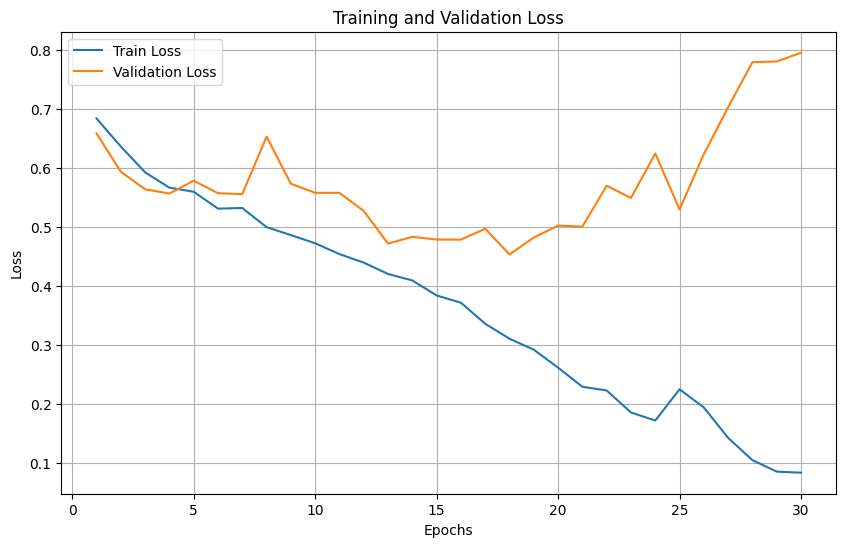

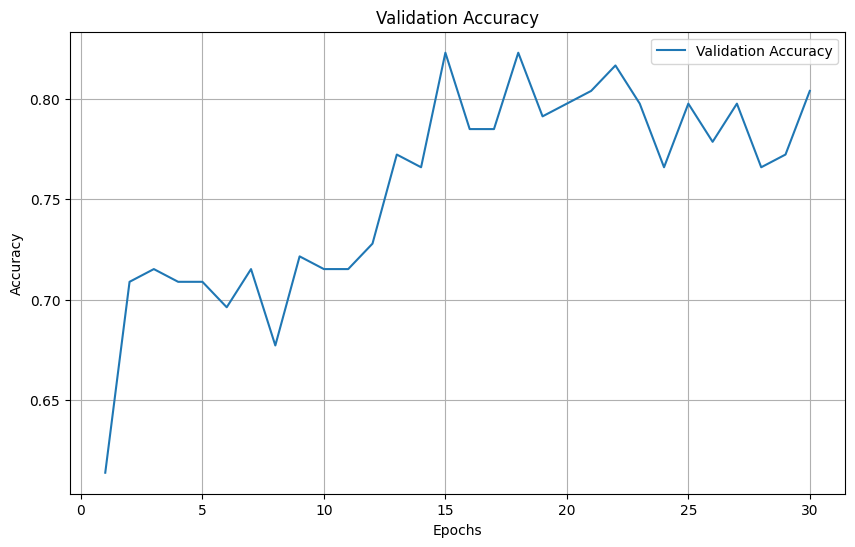

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# === TRAINING LOOP FULL DATA ===
num_epochs = 30
for epoch in range(epochs_so_far, epochs_so_far + num_epochs):
    # Train on small dataset for overfitting
    train_loss = train(baseline_model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(baseline_model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/30
Train Loss: 0.0027
Validation Loss: 1.1844, Validation Accuracy: 0.7532
Epoch 2/30
Train Loss: 0.0025
Validation Loss: 1.2569, Validation Accuracy: 0.7468
Epoch 3/30
Train Loss: 0.0020
Validation Loss: 1.2328, Validation Accuracy: 0.7468
Epoch 4/30
Train Loss: 0.0054
Validation Loss: 1.4751, Validation Accuracy: 0.7785
Epoch 5/30
Train Loss: 0.1293
Validation Loss: 0.9682, Validation Accuracy: 0.7468
Epoch 6/30
Train Loss: 0.0603
Validation Loss: 0.9457, Validation Accuracy: 0.7595
Epoch 7/30
Train Loss: 0.0190
Validation Loss: 1.0536, Validation Accuracy: 0.7405
Epoch 8/30
Train Loss: 0.0120
Validation Loss: 1.1686, Validation Accuracy: 0.7595
Epoch 9/30
Train Loss: 0.0419
Validation Loss: 1.0319, Validation Accuracy: 0.7532
Epoch 10/30
Train Loss: 0.0262
Validation Loss: 1.1071, Validation Accuracy: 0.7532
Epoch 11/30
Train Loss: 0.0076
Validation Loss: 1.0959, Validation Accuracy: 0.7848
Epoch 12/30
Train Loss: 0.0035
Validation Loss: 1.1762, Validation Accuracy: 0.7785
E

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Prepare the training and validation data
X_train = data_training_cleaned['tweet']
y_train = data_training_cleaned['hard_label_task1']
X_val = data_validation_cleaned['tweet']
y_val = data_validation_cleaned['hard_label_task1']

# Initialize the DummyClassifier with the 'uniform' strategy to make random predictions
random_clf = DummyClassifier(strategy='uniform', random_state=random_seed)

# Train the classifier
random_clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = random_clf.predict(X_val)

# Evaluate the classifier
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.48      0.52        90
           1       0.44      0.54      0.49        68

    accuracy                           0.51       158
   macro avg       0.51      0.51      0.51       158
weighted avg       0.52      0.51      0.51       158



# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End